# Code generation with RAG and self-correction

AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [construct an answer to a coding question iteratively.](https://x.com/karpathy/status/1748043513156272416?s=20). 

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it and perform RAG to answer a question based upon it
3. We will invoke a tool to produce a structured output
4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user 

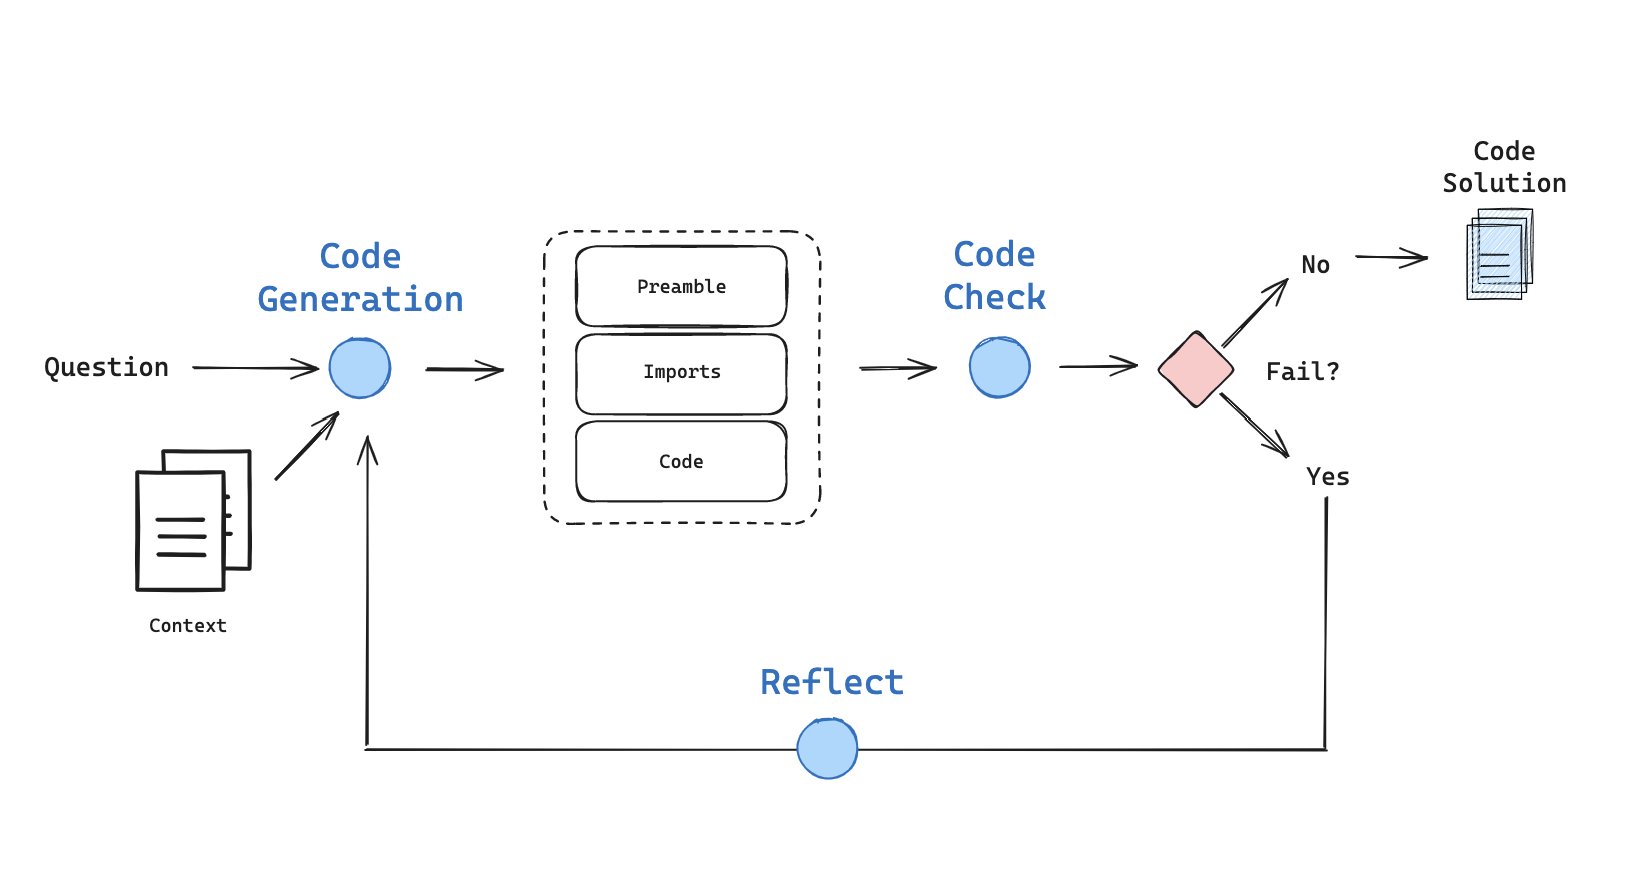

In [ ]:
! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

## Docs

Load [LangChain Expression Language](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) (LCEL) docs as an example.

In [1]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLMs

### Code solution

Try OpenAI and [Claude3](https://docs.anthropic.com/en/docs/about-claude/models) with function calling.

Create `code_gen_chain` w/ either OpenAI or Claude and test here.

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


expt_llm = "gpt-4-0125-preview"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain_oai.invoke({"context":concatenated_content,"messages":[("user",question)]})

In [3]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

### Anthropic

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


# LLM
# expt_llm = "claude-3-haiku-20240307"
expt_llm = "claude-3-opus-20240229"
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

structured_llm_claude = llm.with_structured_output(code, include_raw=True)


# Optional: Check for errors in case tool use is flaky
def check_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""

    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parse error: {error}"
        )

    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! Be sure to invoke the tool to structure the output."
        )
    return tool_output


# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | structured_llm_claude | check_claude_output
)


def insert_errors(inputs):
    """Insert errors for tool parsing in the messages"""

    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }


# This will be run as a fallback chain
fallback_chain = insert_errors | code_chain_claude_raw
N = 3  # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)


def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


# Optional: With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

In [ ]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [4]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

## Graph 

Our graph lays out the logical flow shown in the figure above.

In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [6]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [ ]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
app.invoke({"messages": [("user", question)], "iterations": 0})

## Eval

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) is a public dataset of LCEL questions. 

I saved this as `test-LCEL-code-gen`.

You can also find the csv [here](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv).

In [7]:
import langsmith

client = langsmith.Client()

In [ ]:
# Clone the dataset to your tenant to use it
public_dataset = (
    "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
)
client.clone_public_dataset(public_dataset)

Custom evals.

In [8]:
from langsmith.schemas import Example, Run


def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}


def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

Compare LangGraph to Context Stuffing.

In [9]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    solution_structured = code_gen_chain.invoke([("code", solution)])
    return {"imports": solution_structured.imports, "code": solution_structured.code}


def predict_langgraph(example: dict):
    """LangGraph"""
    graph = app.invoke({"messages": [("user", example["question"])], "iterations": 0})
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [10]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import, check_execution]

# Dataset
dataset_name = "test-LCEL-code-gen"

In [ ]:
# Run base case
experiment_results_ = evaluate(
    predict_base_case,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix=f"test-without-langgraph-{expt_llm}",
    max_concurrency=2,
    metadata={
        "llm": expt_llm,
    },
)

In [ ]:
# Run with langgraph
experiment_results = evaluate(
    predict_langgraph,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix=f"test-with-langgraph-{expt_llm}-{flag}",
    max_concurrency=2,
    metadata={
        "llm": expt_llm,
        "feedback": flag,
    },
)

`Results:`

* `LangGraph outperforms base case`: adding re-try loop improve performance
* `Reflection did not help`: reflection prior to re-try regression vs just passing errors directly back to the LLM
* `GPT-4 outperforms Claude3`: Claude3 had 3 and 1 run fail due to tool-use error for Opus and Haiku, respectively

https://smith.langchain.com/public/78a3d858-c811-4e46-91cb-0f10ef56260b/d